In [1]:
import os
import json
import numpy as np
from skimage.feature import corner_harris, peak_local_max
import cv2
import random

from helpers import *

In [2]:
def computeH(pts1, pts2):    
    A = []
    b = np.zeros(len(pts1)*2 + 1)
    for p1, p2 in zip(pts1, pts2):
        x, y = p1[0], p1[1]
        wx, wy = p2[0], p2[1]
        A.append(np.array([-x, -y, -1, 0, 0, 0, x * wx, y * wx, wx]))
        A.append(np.array([0, 0, 0, -x, -y, -1, x * wy, y * wy, wy]))
    
    A.append(np.array([0, 0, 0, 0, 0, 0, 0, 0, 1]))
    b[-1] = 1
    
    A = np.array(A, dtype=float)
    b = np.array(b, dtype=float)

    h = np.linalg.lstsq(A, b, rcond=None)
    h = h[0]    
    h = h / h[8]
    return h.reshape((3, 3))

def warpImages(im1, H):
    # H == im1 coords -> im2 coords
    x = np.repeat((np.arange(0, im1.shape[1]))[None, ...], im1.shape[0], axis=0)
    y = np.repeat(np.arange(0, im1.shape[0])[..., None], im1.shape[1], axis=1)
    coords = np.stack([x, y, np.ones(x.shape)])

    for i in range(coords.shape[2]):
        coords[:, :, i] = H @ coords[:, :, i]
    
    coords = coords / coords[2]
    coords = coords.astype(int)
    coords[0] = np.clip(coords[0], 0, im1.shape[1] - 1)
    coords[1] = np.clip(coords[1], 0, im1.shape[0] - 1)
    warped_img = im1[coords[1], coords[0], :]
    
    # add alpha channel that is clear on clipped coordinates
    bad_coord_mask = np.multiply(coords[0], coords[1])
    bad_coord_mask[coords[0] == im1.shape[1] - 1] = 0
    bad_coord_mask[coords[1] == im1.shape[0] - 1] = 0
    bad_coord_mask[bad_coord_mask > 0] = 1
    return warped_img, bad_coord_mask

def get_alpha_blend(shape, horizontal=True, left_top=True):
    if horizontal:
        alpha_blend = np.ones(shape)
    else:
        alpha_blend = np.ones(shape).T
    
    if left_top:
        alpha_blend[:, :] = np.linspace(1, 0, alpha_blend.shape[1])
    else:
        alpha_blend[:, :] = np.linspace(0, 1, alpha_blend.shape[1])
    
    if not horizontal:
        return alpha_blend.T
    else:
        return alpha_blend


In [3]:
def get_extra_img(im1, H, H_inv, vertical=True):
    max_coords = H @ np.array([0, im1.shape[0], 1]) 
    max_coords = max_coords / max_coords[2]
    if vertical:
        max_y = int(max_coords[1])

        # create coordinates for im1 outside im2 view
        y = np.repeat(np.arange(im1.shape[0], max_y)[..., None], im1.shape[1], axis=1)
        x = np.repeat(np.arange(0, im1.shape[1])[None, ...], y.shape[0], axis=0)
        
        coords = np.stack([x, y, np.ones(x.shape)])
    else:
        min_x = int(max_coords[0])

        # create coordinates for im1 outside im2 view
        x = np.repeat(np.arange(min_x, 0)[None, ...], im1.shape[0], axis=0)
        y = np.repeat(np.arange(0, im1.shape[0])[..., None], x.shape[1], axis=1)
        coords = np.stack([x, y, np.ones(x.shape)])
        
    for i in range(coords.shape[2]):
        coords[:, :, i] = H_inv @ coords[:, :, i]

    coords = coords / coords[2]
    coords = coords.astype(int)
    coords[0] = np.clip(coords[0], 0, im1.shape[1] - 1)
    coords[1] = np.clip(coords[1], 0, im1.shape[0] - 1)
    extra_img = im1[coords[1], coords[0], :]

    # add alpha channel that is clear on clipped coordinates
    bad_coord_mask = np.multiply(coords[0], coords[1])
    bad_coord_mask[coords[0] == im1.shape[1] - 1] = 0
    bad_coord_mask[coords[1] == im1.shape[0] - 1] = 0
    bad_coord_mask[bad_coord_mask > 0] = 1
    return extra_img, bad_coord_mask

def morph_images_vertical(im1, im2, key1, key2, blend_level=3):
    # im1 is bottom, im2 is top
    # higher blend level -> greater delta in weights for im1 and im2

    H = computeH(key1, key2)
    H_inv = np.linalg.inv(H)
    warped_img, bad_coord_mask = warpImages(im1, H_inv)

    # blend overlapping regions
    warped_alpha = get_alpha_blend(warped_img.shape[:2], horizontal=False, left_top=False)
    warped_alpha = np.clip(bad_coord_mask * warped_alpha**blend_level, 0, 1)
    warped_alpha = np.repeat(warped_alpha[..., None], 3, axis=-1)

    # blend two images together
    blended_img = warped_alpha * warped_img + (1 - warped_alpha) * im2

    # find non overlapping region
    extra_img, _ = get_extra_img(im1, H, H_inv)
    
    # combine blended and extra image
    final_img = np.zeros((extra_img.shape[0] + blended_img.shape[0], max(extra_img.shape[1],  blended_img.shape[1]), 3))    
    final_img[:blended_img.shape[0], :blended_img.shape[1]] = blended_img
    final_img[blended_img.shape[0]:, :] = extra_img
    return final_img

def morph_images_horizontal(im1, im2, key1, key2, blend_level=3):
    # im1 is right, im2 is left??????????
    # higher blend level -> greater delta in weights for im1 and im2

    H = computeH(key1, key2)
    H_inv = np.linalg.inv(H)
    warped_img, bad_coord_mask = warpImages(im1, H_inv)

    # blend overlapping regions
    # TODO check this
    warped_alpha = get_alpha_blend(warped_img.shape[:2], horizontal=True, left_top=True)
    warped_alpha = np.clip(bad_coord_mask * warped_alpha**blend_level, 0, 1)
    warped_alpha = np.repeat(warped_alpha[..., None], 3, axis=-1)

    # blend two images together
    blended_img = warped_alpha * warped_img + (1 - warped_alpha) * im2

    # find non overlapping region
    extra_img, _ = get_extra_img(im1, H, H_inv, vertical=False)
    
    # combine blended and extra image
    final_img = np.zeros((max(extra_img.shape[0], blended_img.shape[0]), extra_img.shape[1] + blended_img.shape[1], 3))    
    final_img[:, :extra_img.shape[1]] = extra_img
    final_img[:, extra_img.shape[1]:] = blended_img

    return final_img


In [240]:
def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1, indices=True)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  
    
    If X has M rows and N columns, and C has L rows and N columns, 
    then the result has M rows and L columns.  The
    I, Jth entry is the squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert dimx == dimc, 'Data dimension does not match dimension of centers'

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)


def compute_robust_keypoints(im_grey, num_points=100):
    h, key = get_harris_corners(im_grey)
    
    distances = dist2(key.T, key.T)

    def compute_r_fast(pt_i):
        c_rob = 0.9
        k = 600

        # find distances
        pt_distances = distances[pt_i]
        top_k_indices = np.argpartition(pt_distances, k)[:k]
        top_k_points = key.T[top_k_indices]

        # find points within threshold
        good_dis = []

        thresh = h[key[:, pt_i][0], key[:, pt_i][1]]
        for k in top_k_points:
            x, y = k[0], k[1]
            if h[x, y] * c_rob > thresh:
                good_dis += [np.linalg.norm(key[:, pt_i] - k)]

        if not len(good_dis) > 0:
            return np.inf

        # take min
        good_dis = np.array(good_dis)
        r = np.min(good_dis)
        return r
    
    r_vals = np.zeros(key.shape[1])
    for i in range(key.shape[1]):
        r_vals[i] = compute_r_fast(i)

    best_points_i = np.argpartition(r_vals, -num_points)[-num_points:]
    best_points = key.T[best_points_i]
    return best_points

def match_keypoints(im1, im2, keypoints_1, keypoints_2, matching_thresh=0.7):
    # get features
    def get_feature(x, y, im):
        # sample
        feature = im[y-20:y+20, x-20:x+20]
        feature = cv2.blur(feature, (5, 5))
        feature = feature[::5, ::5, :]
        # normalize
        feature = (feature - np.mean(feature)) / np.std(feature)
        return feature.flatten()

    features_1 = []
    for k in keypoints_1:
        features_1.append(get_feature(k[1], k[0], im1))

    features_2 = []
    for k in keypoints_2:
        features_2.append(get_feature(k[1], k[0], im2))

    features_1 = np.array(features_1)
    features_2 = np.array(features_2)
    
    # match features
    matched_features_i = []
    for i, f in enumerate(features_1):
        # find 2 closest features in im2
        distances = dist2(f[None, ...], features_2)
        nearest_n = np.argpartition(distances[0], 2)[:2]
        n1 = nearest_n[0]
        n2 = nearest_n[1]
        ratio = distances[0][n1] / distances[0][n2]

        if ratio > matching_thresh:
            continue
        else:
            matched_features_i.append([i, n1])

    matched_features_i = np.array(matched_features_i)
    
    # get good keypoints
    good_key1 = keypoints_1[matched_features_i[:, 0]]
    good_key2 = keypoints_2[matched_features_i[:, 1]]

    good_key1 = np.flip(good_key1, axis=None)
    good_key2 = np.flip(good_key2, axis=None)
    return good_key1, good_key2


def ransac(good_key1, good_key2, iters=200, thresh=3):
    best_inliers_1 = []
    best_inliers_2 = []
    for _ in range(iters):
        rand_keys = random.sample(range(good_key1.shape[0]), 4)
        H = computeH(good_key1[rand_keys], good_key2[rand_keys])
        H_inv = np.linalg.inv(H)

        # find inliers
        inliers_1 = []
        inliers_2 = []
        for correct_k, k in zip(good_key1, good_key2):
            key2_morph = H_inv @ np.array([k[0], k[1], 1])
            key2_morph = key2_morph[:2] / key2_morph[-1]

            diff = np.linalg.norm(key2_morph - correct_k)

            if diff < thresh:
                inliers_1.append(correct_k)
                inliers_2.append(k)

        if len(inliers_1) > len(best_inliers_1):
            best_inliers_1 = inliers_1
            best_inliers_2 = inliers_2
    return best_inliers_1, best_inliers_2



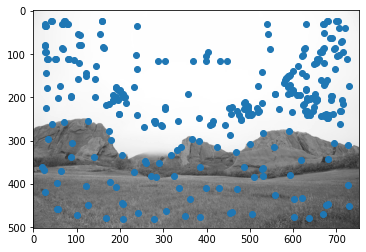

In [261]:
im1 = 'in/red_left.jpeg'
im2 = 'in/red_right.jpeg'

im1 = read(im1)
im2 = read(im2)

#to greyscale
im1_grey = np.mean(im1, axis=-1)
im2_grey = np.mean(im2, axis=-1)

keypoints_1 = compute_robust_keypoints(im1_grey, num_points=300)
keypoints_2 = compute_robust_keypoints(im2_grey, num_points=300)

plt.imshow(im1_grey, cmap='gray')
plt.scatter(keypoints_1.T[1,:], keypoints_1.T[0, :])
plt.show()

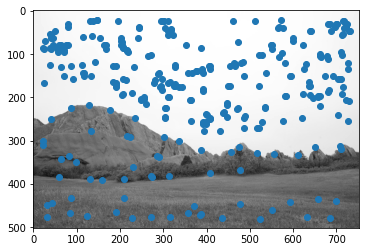

In [262]:
plt.imshow(im2_grey, cmap='gray')
plt.scatter(keypoints_2.T[1,:], keypoints_2.T[0, :])
plt.show()

In [263]:
good_key1, good_key2 = match_keypoints(im1, im2, keypoints_1, keypoints_2, matching_thresh=0.4)
print(len(good_key1))
good_key1, good_key2 = ransac(good_key1, good_key2, thresh=3)
print(len(good_key1))
plt.imshow(im1)
plt.scatter(np.array(good_key1)[:, 0], np.array(good_key1)[:, 1])
plt.show()
plt.imshow(im2)
plt.scatter(np.array(good_key2)[:, 0], np.array(good_key2)[:, 1])
plt.show()

1


ValueError: Sample larger than population or is negative

In [ ]:
morphed_img = morph_images_horizontal(im2, im1, good_key2, good_key1, blend_level=5)
plt.imshow(morphed_img)